In [1]:
import matplotlib.pyplot as plt
import numpy as np

from math import sqrt, exp, pow
from scipy.stats import norm
from scipy.stats import poisson

In [2]:
"""
brownian() implements one dimensional Brownian motion (i.e. the Wiener process).
"""

def brownian(x0, n, dt, delta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

In [197]:
# Set up the paramaters
_mu      = 0.03 
_beta0   = -5.0/16
_beta1   = 1.0/8
_alpha   = -1.0/40
_rho     = -0.3
_chi     = 0.0

In [202]:
N = 23400

# Simulate:
for i in range(1,10):

    # (1) Generate the Poissont realization:
    #_lambda = (3,6)
    #l1 = poisson.rvs(_lambda[1], size=1)
    
    t = np.linspace(0.0, 1.0, N)
    dt = t[2]-t[1]
    
    # Generate the brownian motion:
    bm_dB = brownian(norm.rvs(size=1), N, dt, 1)
    bm_dW = brownian(norm.rvs(size=1), N, dt, 1)
    
    # Estimate the process:
    gamma = np.zeros(t.size)
    sigma = np.zeros(t.size)
    F     = np.zeros(t.size)
    V     = np.zeros(t.size)
    Y1    = np.zeros(t.size)
    Y2    = np.zeros(t.size)
    
    #c0 = (norm.rvs(0, sqrt(-1/(2.0*_alpha)), size=1) + bm_dB[0][0]/_alpha)
    gamma[0] = norm.rvs(size=1)*sqrt(-1/(2.0*_alpha))
    sigma[0] = exp(_beta0 + _beta1*gamma[0])

    for j in range(1,N):
        dB_j     = bm_dB[0][j] - bm_dB[0][j-1]
        #dB_j     = bm_dB[0][j]
        #dW_j     = bm_dW[0][j] - bm_dW[0][j-1]
        gamma[j] = gamma[j-1] + _alpha*gamma[j-1]*dt + dB_j
        #gamma[j] = c0*exp(_alpha*t[j]) #- dB_j/_alpha
        sigma[j] = exp(_beta0 + _beta1*gamma[j])
    
    sigma2 = np.power(sigma, 2)
    # Normalize sigma
    intg = np.sum(sigma2)/N
    sigma2 = sigma2 / intg
    sigma  = np.sqrt(sigma2)
    
    F[0]     = sqrt(1-pow(_rho, 2.0)) * sigma[0] * bm_dW[0][0]
    V[0]     = _rho * sigma[0] * bm_dB[0][0]
    Y1[0]    = 100
    
    for j in range(1,N):
        dB_j     = bm_dB[0][j] - bm_dB[0][j-1]
        dW_j     = bm_dW[0][j] - bm_dW[0][j-1]
        F[j]     = sqrt(1-pow(_rho, 2.0)) * sigma[j] * dW_j
        V[j]     = _rho * sigma[j] * dB_j
        Y1[j]    = Y1[j-1] + _mu*dt + V[j] + F[j] 
        
    U = norm.rvs(size=N)*(_chi**2)*sqrt(np.sum(np.power(sigma, 4))/N)
    Y1 = Y1 + U
    
    # Generate the brownian motion:
    bm_dB = brownian(norm.rvs(size=1), N, dt, 1)
    
    #c0 = (norm.rvs(0, sqrt(-1/(2.0*_alpha)), size=1) + bm_dB[0][0]/_alpha)
    gamma[0] = norm.rvs(size=1)*sqrt(-1/(2.0*_alpha))
    sigma[0] = exp(_beta0 + _beta1*gamma[0])

    for j in range(1,N):
        dB_j     = bm_dB[0][j] - bm_dB[0][j-1]
        #dB_j     = bm_dB[0][j]
        #dW_j     = bm_dW[0][j] - bm_dW[0][j-1]
        gamma[j] = gamma[j-1] + _alpha*gamma[j-1]*dt + dB_j
        #gamma[j] = c0*exp(_alpha*t[j]) #- dB_j/_alpha
        sigma[j] = exp(_beta0 + _beta1*gamma[j])
    
    sigma2 = np.power(sigma, 2)
    # Normalize sigma
    intg = np.sum(sigma2)/N
    sigma2 = sigma2 / intg
    sigma  = np.sqrt(sigma2)
    
    F[0]     = sqrt(1-pow(_rho, 2.0)) * sigma[0] * bm_dW[0][0]
    V[0]     = _rho * sigma[0] * bm_dB[0][0]
    Y2[0]    = 100
    
    for j in range(1,N):
        dB_j     = bm_dB[0][j] - bm_dB[0][j-1]
        dW_j     = bm_dW[0][j] - bm_dW[0][j-1]
        F[j]     = sqrt(1-pow(_rho, 2.0)) * sigma[j] * dW_j
        V[j]     = _rho * sigma[j] * dB_j
        Y2[j]    = Y2[j-1] + _mu*dt + V[j] + F[j] 
        
    U = norm.rvs(size=N)*(_chi**2)*sqrt(np.sum(np.power(sigma, 4))/N)
    Y2 = Y2 + U

In [203]:
np.var(np.power(sigma,2))

0.012366730385985857

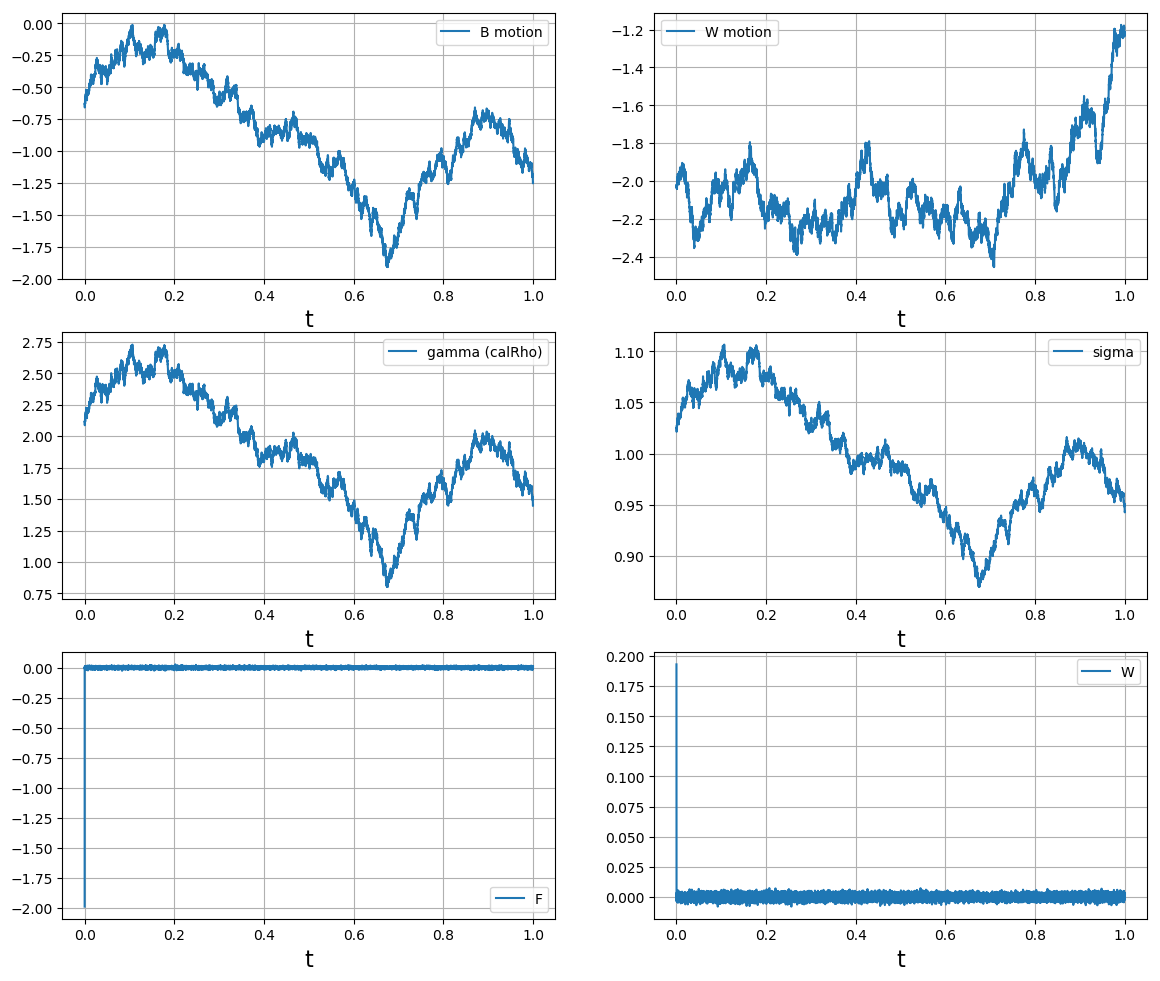

In [204]:
from pylab import plot, show, grid, xlabel, ylabel, subplot, figure, legend

figure(figsize=(14, 12), dpi=100)
subplot(3,2,1)
plot(t, np.transpose(bm_dB[0]))
xlabel('t', fontsize=16)
legend(labels=["B motion"])
grid(True)
subplot(3,2,2)
plot(t, np.transpose(bm_dW[0]))
xlabel('t', fontsize=16)
legend(labels=["W motion"])
grid(True)
subplot(3,2,3)
plot(t, np.transpose(gamma))
xlabel('t', fontsize=16)
legend(labels=["gamma (calRho)"])
grid(True)
subplot(3,2,4)
plot(t, np.transpose(sigma))
xlabel('t', fontsize=16)
legend(labels=["sigma"])
grid(True)
subplot(3,2,5)
plot(t, np.transpose(F))
xlabel('t', fontsize=16)
legend(labels=["F"])
grid(True)
subplot(3,2,6)
plot(t, np.transpose(V))
xlabel('t', fontsize=16)
legend(labels=["W"])
grid(True)
show()

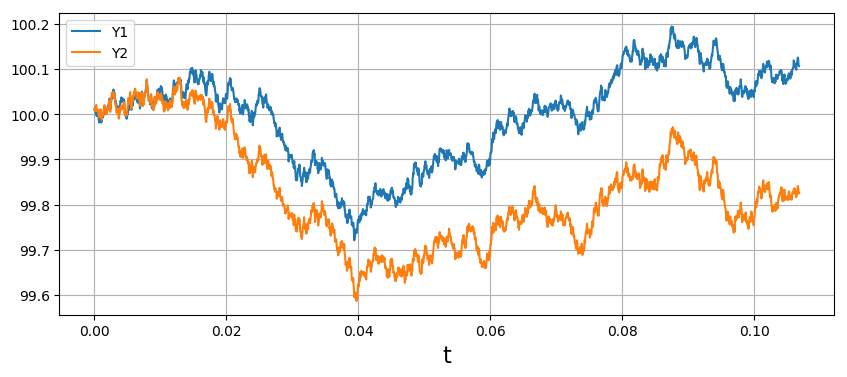

In [205]:
figure(figsize=(10, 4), dpi=100)
plot(t[1:2500], np.transpose(Y1[1:2500]))
plot(t[1:2500], np.transpose(Y2[1:2500]))
xlabel('t', fontsize=16)
legend(labels=["Y1", "Y2"])
grid(True)
show()

In [206]:
np.corrcoef(Y1, Y2)

array([[ 1.        ,  0.60787998],
       [ 0.60787998,  1.        ]])

In [207]:
sqrt(1-pow(_rho, 2.0))

0.9539392014169457